In [40]:
using HDF5
using JLD
using LinearAlgebra
using Statistics
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio
using Plots

In [56]:
#nx, ny = 100, 100 # Size of the grid This are defined later 

# these in shoudl be 50m, biut we are using 1 in MWE_iceflow.jl
Δx, Δy = 50, 50 # meters 
Δt = 1.0/12.0 # scale?
t = 0
t₁ = 3

# Numerical method parameters
tolnl = 0.0 # 1e-4  # this ensures that we are going to run always itMax iterations, independenly of the error
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
nout = 5                # error check frequency
cfl  = max(Δx^2,Δy^2)/4.1
D_max = 500000 # maximum value of expected diffusivity

# Glacier parameters 
#A₀ = 1
ρ = 900 # wrong units? Should it be 900 kg/m^3?
g = 9.81
n = 3

3

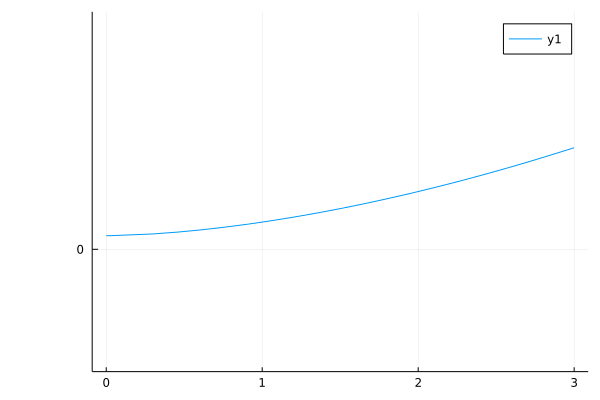

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/2GoqU/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/facundosapienza/.julia/packages/PlotUtils/2GoqU/src/ticks.jl:295


In [42]:
fakeA(t) = (1 + t^1.7)*1e-17
plot(fakeA, 0, t₁)

In [43]:
@views avg(A) = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )
@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )
@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )

avg_y (generic function with 1 method)

In [59]:
function iceflow!(H,t,t₁)

    println("Running forward PDE ice flow model...\n")
    # Instantiate variables
    
    let             

    total_iter = 0
    ts_i = 1

    # Manual explicit forward scheme implementation
    while t < t₁
            
        let
        iter = 1
        err = 10e10
        Hold = copy(H) # hold value of H for the other iteration in the implicit method
        dHdt = zeros(nx, ny) # with Tullio

        # Get current year for MB and ELA
        year = floor(Int, t) + 1

        A = fakeA(t)

        while err > tolnl && iter < itMax+1

            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid

            F, dτ = SIA(H, A)

            # implicit method with Tullio  
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]

            H_ = copy(H)
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ) #[pad(i-1,1,1),pad(j-1,1,1)])


            if mod(iter, nout) == 0
                # Compute error for implicit method with damping
                Err = Err .- H
                err = maximum(Err)
                println("error at iter ", iter, ": ", err)

                if isnan(err)
                    error("""NaNs encountered.  Try a combination of:
                                decreasing `damp` and/or `dtausc`, more smoothing steps""")
                elseif err>10e8
                    error("""Inestability detected""")
                end
            end

            iter += 1
            total_iter += 1
        end

        t += Δt

        end

    end 

    #println("Total Number of iterartions: ", total_iter)
    end

    return H
end

iceflow! (generic function with 1 method)

In [60]:
function SIA(H, A)

    # Update glacier surface altimetry
    # S = B .+ H
    S = H

    # All grid variables computed in a staggered grid
    # Compute surface gradients on edges
    dSdx  = diff(S, dims=1) / Δx
    dSdy  = diff(S, dims=2) / Δy
    ∇S = sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)

    Γ = 2 * A * (ρ * g)^n / (n+2)
    
    D = Γ .* avg(H).^(n + 2) .* ∇S.^(n - 1) 
  
    # Compute flux components
    dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
    dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
    Fx = .-avg_y(D) .* dSdx_edges
    Fy = .-avg_x(D) .* dSdy_edges    
    #  Flux divergence
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 

    # Compute dτ for the implicit method
    if D_max < maximum(D)
        error("Upper bound of diffusivity reached. Increase the value of D_max to ensure stability. ")
    end
    #dτ = dτsc * min.( 10.0 , 1.0./(1.0/Δt .+ 1.0./(cfl./(ϵ .+ avg(D)))))
    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D_max))))


    return F, dτ

end

SIA (generic function with 1 method)

### Generate reference dataset

In [61]:
#dataset = 'fake'
dataset = "Argentiere"

if dataset == "fake"

    H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]
    
elseif dataset == "Argentiere"
    
    root_dir = "/Users/facundosapienza/Dropbox/Glacier UDE/ODINN_toy" #cd(pwd, ".")
    argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5"), "r")

    mutable struct Glacier
        bed::Array{Float64}    # bedrock height
        thick::Array{Float64}  # ice thickness
        vel::Array{Float64}    # surface velocities
        MB::Array{Float64}     # surface mass balance
        lat::Float64
        lon::Float64
    end
    
    # Fill the Glacier structure with the retrieved data
    argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                         HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["s_apply_hist"])[begin:end-2,:,2:end],
                         0, 0);
    
    nx = size(argentiere.bed)[1]
    ny = size(argentiere.bed)[2]
    
    H₀ = argentiere.thick[:,:,1]
    
end

193×189 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

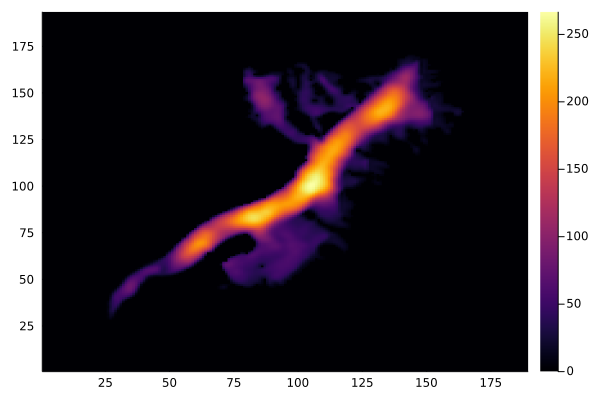

In [62]:
heatmap(H₀, clim=(0, maximum(H₀)))

In [63]:
H₁ = iceflow!(H₀,t,t₁)

Running forward PDE ice flow model...

error at iter 5: 2.629489275892155
error at iter 10: 2.0153558090915453
error at iter 15: 1.48435161611485
error at iter 20: 1.1006110868993915
error at iter 25: 0.8303979110994106
error at iter 30: 0.47557884459797606
error at iter 35: 0.5775278208610928
error at iter 40: 0.36643107295567745
error at iter 45: 0.23511045131579067
error at iter 50: 0.26119547847876845
error at iter 55: 0.22823464443218455
error at iter 60: 0.16067699172151606
error at iter 65: 0.09795450926981886
error at iter 70: 0.051735873427823265
error at iter 75: 0.04933395402847651
error at iter 80: 0.03999186517691555
error at iter 85: 0.02768147703175572
error at iter 90: 0.018316331114178297
error at iter 95: 0.014071257383093894
error at iter 100: 0.010568082428328296
error at iter 5: 0.37265183117384026
error at iter 10: 0.44584442867090956
error at iter 15: 0.4157703041751972
error at iter 20: 0.3540831153755164
error at iter 25: 0.2780170173768113
error at iter 30: 0.

error at iter 65: 0.007419999252334719
error at iter 70: 0.005656618557736692
error at iter 75: 0.0043060121743394575
error at iter 80: 0.003274699363117861
error at iter 85: 0.0024889069467803893
error at iter 90: 0.0018910981370083846
error at iter 95: 0.0014367751912232052
error at iter 100: 0.0010917321445162997
error at iter 5: 0.0472950805672383
error at iter 10: 0.06346237948102385
error at iter 15: 0.06418310620148304
error at iter 20: 0.05799099416532272
error at iter 25: 0.04937236383381105
error at iter 30: 0.04055927543981852
error at iter 35: 0.03255736749773064
error at iter 40: 0.02573609118786635
error at iter 45: 0.02012694889972977
error at iter 50: 0.01561878587352794
error at iter 55: 0.012053124285557715
error at iter 60: 0.009264240894111708
error at iter 65: 0.007100147890440667
error at iter 70: 0.005430412463141465
error at iter 75: 0.004147388315232092
error at iter 80: 0.0031644261171663857
error at iter 85: 0.0024129403689983064
error at iter 90: 0.001839274

error at iter 20: 0.036554472433124374
error at iter 25: 0.03140855961919442
error at iter 30: 0.026080498885818315
error at iter 35: 0.021190155306157976
error at iter 40: 0.01696915413654665
error at iter 45: 0.013454712420809756
error at iter 50: 0.010594441682286515
error at iter 55: 0.008301460347723832
error at iter 60: 0.0064821249181648
error at iter 65: 0.005048941524961492
error at iter 70: 0.0039256665375830835
error at iter 75: 0.003048459047874985
error at iter 80: 0.0023651780047941884
error at iter 85: 0.0018339294768736636
error at iter 90: 0.0014214252191209198
error at iter 95: 0.0011014185265594278
error at iter 100: 0.0008533270807049576
error at iter 5: 0.028277462105279483
error at iter 10: 0.038079973706800274
error at iter 15: 0.03873670091363124
error at iter 20: 0.03527531770794212
error at iter 25: 0.030325275420864273
error at iter 30: 0.025196339815124702
error at iter 35: 0.020485864595826797
error at iter 40: 0.01641754074569235
error at iter 45: 0.013027

error at iter 70: 0.003039424699210258
error at iter 75: 0.002378913114455372
error at iter 80: 0.0018604385295475367
error at iter 85: 0.0014541461031853942
error at iter 90: 0.0011361445910722523
error at iter 95: 0.0008874578000757083
error at iter 100: 0.0006930919520584666
error at iter 5: 0.020544920659489208
error at iter 10: 0.027707060082036605
error at iter 15: 0.02825141029865108
error at iter 20: 0.025809265161257144
error at iter 25: 0.022275415016736133
error at iter 30: 0.018593789761666812
error at iter 35: 0.015196758886247608
error at iter 40: 0.012248770404767129
error at iter 45: 0.009779912019183712
error at iter 50: 0.007757904292219564
error at iter 55: 0.006125932868684458
error at iter 60: 0.004821736774829333
error at iter 65: 0.003786575577265694
error at iter 70: 0.0029688612180223117
error at iter 75: 0.0023250826903904454
error at iter 80: 0.0018194450421162855
error at iter 85: 0.0014229742607483331
error at iter 90: 0.0011124713943786446
error at iter 95

193×189 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

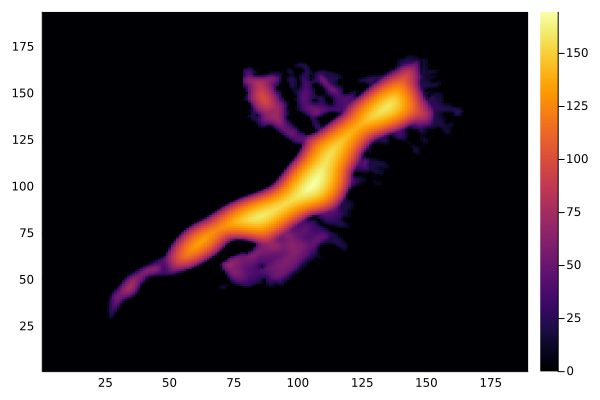

In [64]:
heatmap(H₁, clim=(0, maximum(H₁)))

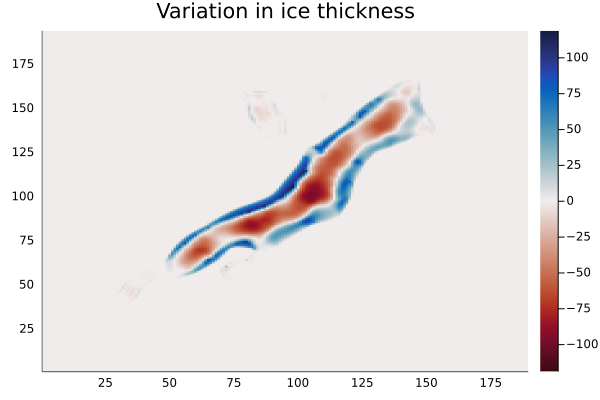

In [66]:
lim = maximum( abs.(H₁ .- H₀) )
heatmap(H₁ .- H₀, c = cgrad(:balance,rev=true),   clim = (-lim, lim), title="Variation in ice thickness")

In [67]:
lim

118.80276753618637